# Assignment 2
# FIT 5202 - Data processing for Big Data

## Rain in Australia: Predict rain tomorrow in Australia
Predicting rain or weather is a common problem in machine learning. Different machine learning algorithms can be used to model and predict rainfall. In this assignment, we ask you to complete the analysis to predict whether there will be rain tomorrow or not. In particular, you are required to apply the tools of machine learning to visualize and predict the possibility of rainfall in Australia.

*Required Datasets (available in Moodle)*:
- Rain in Australia **(weatherAUS.csv)**


## Import Libraries

In [1]:
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
import matplotlib.pyplot as plt # importing the visualization library
import numpy as np
%matplotlib inline
from pyspark.mllib.evaluation import MulticlassMetrics

## A. Creating Spark Session and Loading the Data

### Step 01: Import Spark Session and initialize Spark
**pyspark** is the Spark Python API that exposes the Spark programming model to Python. You are already familiar with **sparkContext** from Assignment 1. **sparkContext** was used as a channel to access all spark functionality. In order to use APIs of SQL, HIVE, and Streaming, separate contexts need to be created. From SPARK 2.0.0 onwards **sparkSession** provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with Dataframe and Dataset APIs. All the functionality available with **sparkContext** are also available in **sparkSession**. Write the code to create a sparkSession object, with 4 local cores. To create a sparkSession with 4 core you have to use configure it as *local[4]*. Give a name to your program using *appName()*.

In [2]:
# create entry points to spark
sc = SparkContext.getOrCreate()

# We will build a configuration 
conf = SparkConf()
conf.set("spark.app.name", "Assignment 2")
conf.set("spark.master", "local[4]")

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(conf=conf)
spark = SparkSession(sparkContext=sc)

### Step 02: Load the dataset and print the schema and total number of entries
In *sparkSession* you can use *spark_session.read.csv()* method to load data as CSV format. You can download the dataset from Moodle. After you load the csv file into a dataframe using spark session, write the code to print the total number of entries in the dataset.

In [3]:
df_weatherAUS = spark.read.csv("weatherAUS.csv", header = True)
print('The dataframe has:',df_weatherAUS.count(), 'records')

The dataframe has: 142193 records


In [4]:
df_weatherAUS.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## B. Data Cleaning and Processing
Data cleaning and processing is an important aspect for any machine learning task. We have to carefully look into the data and based on the types, quality of the data, we have to plan our cleaning procedures.

### Step 03: Delete columns from the dataset
During the data cleaning and processing phase, we delete unnecessary data from the dataset to improve the efficiency and accuracy of our model. You have to think which columns are not contributing to the rain prediction. To keep things simple, you are required to delete the following columns due to data quality and accuracy.
- Date
- Location
- Evaporation
- Sunshine
- Cloud9am
- Cloud3pm
- Temp9am
- Temp3pm <br>
However, if you want to keep any of these columns, you can keep them if you process them in an intelligent way that improve the accuracy, that is fine, **however not mandatory**.

In [5]:
df_weatherAUS_clean = df_weatherAUS.drop(*["Date", "Location", "Evaporation",
                                           "Sunshine","Cloud9am", "Cloud3pm","Temp9am","Temp3pm"])
df_weatherAUS_clean.columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']

### Step 04: Print the number of missing data in each column.
We already have an initial idea about the data structure from the schema. Even in plain eyes, we can observe that there are lots of NA (null) values in the given dataset. Your job in this step is to print the number of NA(null) values in each column.

<font color = "green"><b>
Firstly, we will use the method the built-in method <i>isnan</i>, that will return what is being recognized as a null in the dataframe, associated with the count function. 

In [6]:
# counting nas
df_weatherAUS_clean.select([count(when(isnan(c), c)).alias(c) for c in df_weatherAUS_clean.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



<font color = "green"><b>
Since we haven't found any null value, we will count 'NAs', as was asked in the question. Our approach now will be to search for strings that are equal to this characters.

In [7]:
# create a function
def countNA(df):
    for column in df.columns:  
        print(column, ":", df.filter(df[column] == 'NA').count())

countNA(df_weatherAUS_clean)

MinTemp : 637
MaxTemp : 322
Rainfall : 1406
WindGustDir : 9330
WindGustSpeed : 9270
WindDir9am : 10013
WindDir3pm : 3778
WindSpeed9am : 1348
WindSpeed3pm : 2630
Humidity9am : 1774
Humidity3pm : 3610
Pressure9am : 14014
Pressure3pm : 13981
RainToday : 1406
RainTomorrow : 0


<font color = "green"><b>
With the exception of the column RainTomorrow, all columns have NA's, some more than others. We will proceed assuming this are all null values in the dataframe.

### Step 05: Fill the missing data with average value and maximum occurrence value.
In this step you have to fill in all the missing data with average value (for numeric column) or maximum frequency value (for non-numeric column). Firstly, identify the columns which have numeric values (e.g., MinTemp, MaxTemp), calculate the average and fill the null value with the average.

<font color = "green"><b>
As we have seen in step 2 with the printSchema(), all columns are caracterized as string. To identify the columns that numerical and categorical we will print the first row and make the classification by eye. 

In [8]:
# Print first row to identify categorical and numerical values
df_weatherAUS_clean.take(1)

[Row(MinTemp='13.4', MaxTemp='22.9', Rainfall='0.6', WindGustDir='W', WindGustSpeed='44', WindDir9am='W', WindDir3pm='WNW', WindSpeed9am='20', WindSpeed3pm='24', Humidity9am='71', Humidity3pm='22', Pressure9am='1007.7', Pressure3pm='1007.1', RainToday='No', RainTomorrow='No')]

In [9]:
# Create lists for numerical and categorical columns 
numerical_cols = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm']

categorical_cols = ['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']

<font color = "green"><b>
To find the average of numerical columns the method <i>describe</i> will be used, as it is particularly to find stats data from dataframes. 

In [10]:
# Extracting information of mean 
df_summary = df_weatherAUS_clean.select(numerical_cols).describe().collect()
mean_list = df_summary[1] # extracting mean list - the column index 1 has the values of means

for item in mean_list.asDict().items():    
    print(item)

('summary', 'mean')
('MinTemp', '12.186399728729098')
('MaxTemp', '23.226784191272444')
('Rainfall', '2.3499740743111954')
('WindGustSpeed', '39.98429165757619')
('WindSpeed9am', '14.001988000994')
('WindSpeed3pm', '18.63757586179718')
('Humidity9am', '68.8438103105705')
('Humidity3pm', '51.482606091656265')
('Pressure9am', '1017.6537584159781')
('Pressure3pm', '1015.258203537907')


<font color = "green"><b>
Unfortunately, the same method cannot be used to find the maximum frequency and another approach must be taken. A groupby with count sorted will return the maximum frequency values.

In [11]:
# Extracting information of mode 
count_list = []
for column in categorical_cols:
    df = df_weatherAUS_clean.groupBy(column).count()
    mode = df.orderBy(df['count'].desc()).collect()[0][0]
    count_list.append(mode)
    print(column, ":", mode)

WindGustDir : W
WindDir9am : N
WindDir3pm : SE
RainToday : No
RainTomorrow : No


<font color = "green"><b>
In our next step we will make the replacements using the lists that we just generated, `mean_list`and `count_list`. 

In [12]:
for column in numerical_cols:
    df_weatherAUS_clean = df_weatherAUS_clean.withColumn(column, regexp_replace(column, 'NA', mean_list[column]))

support_count = 0    
for column in categorical_cols:
    df_weatherAUS_clean = df_weatherAUS_clean.withColumn(column, regexp_replace(column, 'NA', count_list[support_count]))
    support_count += 1

<font color = "green"><b>
Using the function created in step 4, `countNA`, lets check if the replacement was successful.  

In [13]:
countNA(df_weatherAUS_clean)

MinTemp : 0
MaxTemp : 0
Rainfall : 0
WindGustDir : 0
WindGustSpeed : 0
WindDir9am : 0
WindDir3pm : 0
WindSpeed9am : 0
WindSpeed3pm : 0
Humidity9am : 0
Humidity3pm : 0
Pressure9am : 0
Pressure3pm : 0
RainToday : 0
RainTomorrow : 0


### Step 06: Data transformation
In this step, you need to transform the data so that it will be useful to process by
the machine learning algorithm. Before transforming your non-numerical data, do the
type casting (to double) of the numerical value columns as they are defined as “String”
(see, the schema of the dataset). For the non-numerical value column (i.e., WindGustDir,
WindDir9am, WindDir3pm, RainTomorrow) use the StringIndexer method to convert
them into numbers.

In [14]:
# conversion of column type
for column in numerical_cols:
    df_weatherAUS_clean = df_weatherAUS_clean.withColumn(column, df_weatherAUS_clean[column].cast('double'))

for column in categorical_cols:
    l_indexer = StringIndexer(inputCol = column, outputCol = column+"index")
    df_weatherAUS_clean = l_indexer.fit(df_weatherAUS_clean).transform(df_weatherAUS_clean)
    df_weatherAUS_clean = df_weatherAUS_clean.drop(column) # dropping the column 
    
df_weatherAUS_clean.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- WindGustDirindex: double (nullable = false)
 |-- WindDir9amindex: double (nullable = false)
 |-- WindDir3pmindex: double (nullable = false)
 |-- RainTodayindex: double (nullable = false)
 |-- RainTomorrowindex: double (nullable = false)



<font color = "green"><b>
The printSchema demonstrates that the task has been successful. We have:
- Converted all numerical columns to double
- Created indexcolumns type double with numerical values replacing previous strings
- Droped previous categorical columns 

### Step 07: Create the feature vector and divide the dataset
In this step, you have to create the feature vector from the given columns. When
you create you feature vector, remember to exclude the column that you will be using
for testing the accuracy of your model.
After creation of your feature vector, you have ​ to split your dataset into two (e.g., training
and testing). In this assignment, you have to spit the dataset randomly and between 70
percent and 30 percent.

<font color = "green"><b>
To create a feature vector we will use the functions `VectorAssembler and vector_assembler.transform`. Once the colum is created and the others are droped the new dataframe will be printed.

In [15]:
vector_assembler = VectorAssembler(
    inputCols=["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed","WindSpeed9am",
                "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am","Pressure3pm",
               "WindGustDirindex", "WindDir9amindex","WindDir3pmindex", "RainTodayindex"],
    outputCol="features")


df_weatherAUS_clean = vector_assembler.transform(df_weatherAUS_clean)

# Drop all unwanted columns 
cols_list = ["features", "RainTomorrowindex"]
df_weatherAUS_clean = df_weatherAUS_clean.select([cols for cols in df_weatherAUS_clean.columns if cols in cols_list])

df_weatherAUS_clean.show(3)

+-----------------+--------------------+
|RainTomorrowindex|            features|
+-----------------+--------------------+
|              0.0|[13.4,22.9,0.6,44...|
|              0.0|[7.4,25.1,0.0,44....|
|              0.0|[12.9,25.7,0.0,46...|
+-----------------+--------------------+
only showing top 3 rows



<font color = "green"><b>
Great, now we will split the data in train and test using `randomSplit`. 

In [16]:
(trainingData, testData) = df_weatherAUS_clean.randomSplit([0.7, 0.3], seed = 1234)

# C. Apply Machine Learning Algorithms
**Step 08: Apply machine learning classification algorithms on the dataset and
compare their accuracy. Plot the accuracy as bar graph.**<br>
You have to use ​ DecisionTreeClassifier(), RandomForestClassifier(), and
LogisticRegression(), GBTClassifier() methods in spark to calculate the probability of the
rain fall tomorrow based on the other related data points (e.g., temperature, wind,
humidity). Finally, you have to draw the graph (e.g. bar chart) to demonstrate the
comparison of their accuracy.

<font color = "green"><b>
Create a evaluator `MulticlassClassificationEvaluator` to calculate accuracy.

In [17]:
evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowindex", 
                                              predictionCol="prediction", metricName="accuracy")

<font color = "green"><b>
Now we will apply similar methods to create models as asked. A new dataframe will be genareted from the trainning data for each classifier and accuracy will be calculated in sequence.

<font color = "green"><b>
Decision Tree Classifier

In [18]:
dt = DecisionTreeClassifier(labelCol="RainTomorrowindex", featuresCol="features", seed = 1000)

dt_model = dt.fit(trainingData)

dt_predictions = dt_model.transform(testData)

dt_predictions.select("prediction", "RainTomorrowindex").show(5)

dt_accuracy = evaluator.evaluate(dt_predictions)

print("Test Error = %g " % (1.0 - dt_accuracy))
print("Accuracy", dt_accuracy)

+----------+-----------------+
|prediction|RainTomorrowindex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Test Error = 0.164488 
Accuracy 0.8355119056030523


<font color = "green"><b>
Random Forest Classifier

In [19]:
rf = RandomForestClassifier(labelCol="RainTomorrowindex", featuresCol="features", numTrees=10, seed = 1000)
rf_model = rf.fit(trainingData)

rf_predictions = rf_model.transform(testData)

rf_predictions.select("prediction", "RainTomorrowindex").show(5)

rf_accuracy = evaluator.evaluate(rf_predictions)

print("Test Error = %g" % (1.0 - rf_accuracy))
print("Accuracy", rf_accuracy)

+----------+-----------------+
|prediction|RainTomorrowindex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Test Error = 0.164135
Accuracy 0.8358651875927365


<font color = "green"><b>
Logistic Regression

In [20]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrowindex', maxIter=10)
lr_model = lr.fit(trainingData)

lr_predictions = lr_model.transform(testData)

lr_predictions.select("prediction", "RainTomorrowindex").show(5)

lr_accuracy = evaluator.evaluate(lr_predictions)

print("Test Error = %g" % (1.0 - lr_accuracy))
print("Accuracy", lr_accuracy)

+----------+-----------------+
|prediction|RainTomorrowindex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Test Error = 0.183801
Accuracy 0.8161991568336513


<font color = "green"><b>
GBT Classifier

In [21]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'RainTomorrowindex', maxIter=10, seed = 1000)
gbt_model = gbt.fit(trainingData)

gbt_predictions = gbt_model.transform(testData)

gbt_predictions.select("prediction", "RainTomorrowindex").show(5)

gbt_accuracy = evaluator.evaluate(gbt_predictions)

print("Test Error = %g" % (1.0 - gbt_accuracy))
print("Accuracy", gbt_accuracy)

+----------+-----------------+
|prediction|RainTomorrowindex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Test Error = 0.158765
Accuracy 0.8412350738359359


<font color = "green"><b>
Plotting the Accuracies

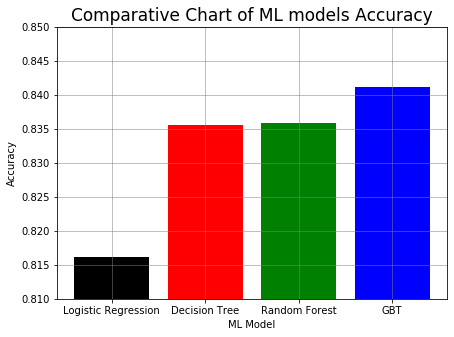

In [22]:
plt.figure(figsize=(7,5))

model = [lr_accuracy, dt_accuracy, rf_accuracy, gbt_accuracy]
bars = ( 'Logistic Regression', 'Decision Tree', 'Random Forest', 'GBT')
y_pos = np.arange(len(bars))

plt.title('Comparative Chart of ML models Accuracy', fontsize = 17)
plt.ylabel('Accuracy')
plt.xlabel('ML Model')
plt.ylim(0.81, 0.85)
plt.grid(linestyle='-', linewidth='0.5', color='grey')

plt.bar(y_pos, model, color=['black', 'red', 'green', 'blue'])
plt.xticks(y_pos, bars)
plt.show()


<font color = "green"><b>
We can observe in the plot that the GBT model had the best accuracy, followed by Random forest, Decision Tree and finally Logistic Regression. Nevertheless, all accuracies are quite similar, in a range between 0.81 and 0.85.

**Step 09: Calculate the confusion matrix and find the precision, recall, and F1
score of each classification algorithm. Explain how the accuracy of the
predication can be improved?**<br>
    Finding the accuracy of the model does not always represent the quality of the
model for a given dataset. Number of false positive and false negative identification also
plays an important role when we decide about any particular classification model. The
way we can calculate is called confusion matrix. You can use confusionMatrix() method
to calculate the confusion matrix. From the confusion matrix show the precision, recall
and f1 score of each classification model. Explain how you can improve the accuracy of
the ​ prediction​ .

In [28]:
def printstats(RDD):
    
    metrics = MulticlassMetrics(RDD)
    Confusion_matrix = metrics.confusionMatrix().toArray()

    print("Confusion Matrix\n")
    print(Confusion_matrix)    
    print('\n')
    print('True Positives:',  Confusion_matrix[1][1])
    print('False Positives:', Confusion_matrix[0][1])
    print('False Negatives:', Confusion_matrix[1][0])
    print('True Negatives:',  Confusion_matrix[0][0])
    print('\n')

    precision = Confusion_matrix[1][1]/(Confusion_matrix[1][1] + Confusion_matrix[0][1])   
    recall = Confusion_matrix[1][1]/(Confusion_matrix[1][1] + Confusion_matrix[1][0])    
    F1 = 2*precision*recall/(precision+recall)
    
    print('Precision:', precision)    
    print('Recall:', recall)
    print('F1:',  F1)
    print('\n')


<font color = "green"><b>
Evaluation of Decision Tree Model

In [29]:
dt_pred_RDD = dt_predictions.select("prediction", "RainTomorrowindex").rdd.map(lambda line: (line[0], line[1]))
printstats(dt_pred_RDD)

Confusion Matrix

[[31850.  1117.]
 [ 5867.  3625.]]


True Positives: 3625.0
False Positives: 1117.0
False Negatives: 5867.0
True Negatives: 31850.0


Precision: 0.7644453816954871
Recall: 0.38190054782975136
F1: 0.5093438246452157




<font color = "green"><b>
Evaluation of Random Forest

In [30]:
rf_pred_RDD = rf_predictions.select("prediction", "RainTomorrowindex").rdd.map(lambda line: (line[0], line[1]))
printstats(rf_pred_RDD)

Confusion Matrix

[[31802.  1165.]
 [ 5804.  3688.]]


True Positives: 3688.0
False Positives: 1165.0
False Negatives: 5804.0
True Negatives: 31802.0


Precision: 0.7599423037296518
Recall: 0.3885377159713443
F1: 0.514186127570582




<font color = "green"><b>

Evaluation of Logistic Regression

In [31]:
lr_pred_RDD = lr_predictions.select("prediction", "RainTomorrowindex").rdd.map(lambda line: (line[0], line[1]))
printstats(lr_pred_RDD)

Confusion Matrix

[[30616.  2351.]
 [ 5453.  4039.]]


True Positives: 4039.0
False Positives: 2351.0
False Negatives: 5453.0
True Negatives: 30616.0


Precision: 0.6320813771517997
Recall: 0.42551622418879054
F1: 0.5086261176174286




<font color = "green"><b>
Evaluation of GBT

In [32]:
GBT_pred_RDD = gbt_predictions.select("prediction", "RainTomorrowindex").rdd.map(lambda line: (line[0], line[1]))
printstats(GBT_pred_RDD)

Confusion Matrix

[[31474.  1493.]
 [ 5248.  4244.]]


True Positives: 4244.0
False Positives: 1493.0
False Negatives: 5248.0
True Negatives: 31474.0


Precision: 0.739759456161757
Recall: 0.4471133586177834
F1: 0.5573576728609889




<font color = "green"><b>
Improving model accuracy: To improve the accuracy of machine learning models there are many possible approaches, altough none of then are guarateed to work. 

- Firstly, if possible, adding more data will much likely contribute to a better model accuracy. 
- We could investigate if there was a better approach to handle missing data. For instance, to replace missing categorical missing values, a multinomial logistic regression, or a K Nearest Neighbors regression could be tried. In respect to numerical values, a simple regression would possibly be better than replacing by the mean. Also, may be they are not "missing at random", which means there is a specific reason the data is missing, and once it is found it possibile to make a better rule for replacement than the one that were used.  
- Investigating and eliminating outliers is also a possibility, as they may generate bias to the model.
- Feature selection, and I would like to point out this as the most relevant at this point. As we can see in this [link](https://datascienceplus.com/weather-forecast-with-regression-models-part-1/), some of the columns shouldn't have been excluded, specially `Cloud9am` and`Cloud3pm`. This conclusion came from the fact that this variables have different distributions on days before rain and before sunny days, which indicates they can have a good predictive power.
- Finally another option would be to algorithm Tuning, which mean work on the hyperparameters of the models and try to improve the accuracy. For instance, in a random forest a key parameter is the number of trees, so we should raise the number of trees significantly, but with care, otherwise we can start overfitting the model and accuracy will decrease. With respects to Decision Trees, increasing the parameter max_depth also can be used to improve accuracy, specially when there are many features and complex data (but with concerns to overffiting). Gradient boost trees can be improved by Tree-Specific Parameters, they affect each individual tree in the model, Boosting Parameters, that affect the boosting operation in the model and Miscellaneous Parameters, other parameters for overall functioning. Increasing the parameter min_samples_leaf, for instance, would be a fear try to increase accuracy, as there are many feautures being modelled. In respect to logistic Regression the best parameter to target is 'maxiter'.<br><br><br><br>

References:<br>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4 <br>
https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/ <br>
https://datascienceplus.com/weather-forecast-with-regression-models-part-1/ <br>
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
